## Import Library

In [73]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [74]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        7500 non-null   object 
 1   Exercise_Duration         7500 non-null   float64
 2   Body_Temperature(F)       7500 non-null   float64
 3   BPM                       7500 non-null   float64
 4   Height(Feet)              7500 non-null   float64
 5   Height(Remainder_Inches)  7500 non-null   float64
 6   Weight(lb)                7500 non-null   float64
 7   Weight_Status             7500 non-null   object 
 8   Gender                    7500 non-null   object 
 9   Age                       7500 non-null   int64  
 10  Calories_Burned           7500 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 644.7+ KB


## Preprocessing

In [76]:
le = LabelEncoder()
train_df['Weight_Status'] = le.fit_transform(train_df['Weight_Status'])
le = LabelEncoder()
train_df['Gender'] = le.fit_transform(train_df['Gender'])
le = LabelEncoder()
test_df['Weight_Status'] = le.fit_transform(test_df['Weight_Status'])
le = LabelEncoder()
test_df['Gender'] = le.fit_transform(test_df['Gender'])

## Visualization

<ipython-input-60-6c3475b36d78>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot = True)


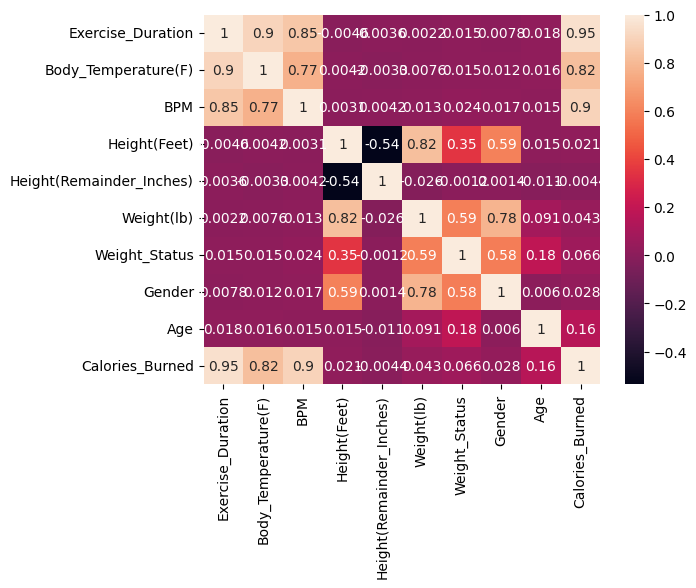

In [60]:
sns.heatmap(train_df.corr(), annot = True)
plt.show()

## Feature Engineering

In [77]:
train_df['Height_Full'] = train_df['Height(Feet)'] * 12 + train_df['Height(Remainder_Inches)']
test_df['Height_Full'] = test_df['Height(Feet)'] * 12 + test_df['Height(Remainder_Inches)']

train_df.drop(columns = ['Height(Feet)', 'Height(Remainder_Inches)','ID'], inplace = True)
test_df.drop(columns = ['Height(Feet)', 'Height(Remainder_Inches)','ID'], inplace = True)

# Age range
train_df['Age_range'] = train_df['Age'] //10
test_df['Age_range'] = test_df['Age']//10

In [78]:
gender_mean = train_df.groupby('Gender').mean()
gender_mean.drop(columns = gender_mean.columns.drop('Calories_Burned'), inplace = True)
gender_mean.rename(columns = {'Calories_Burned':'Gender_mean'}, inplace = True)

weight_mean = train_df.groupby('Weight_Status').mean()
weight_mean.drop(columns = weight_mean.columns.drop('Calories_Burned'), inplace = True)
weight_mean.rename(columns = {'Calories_Burned':'Weight_mean'}, inplace = True)

# age_range_mean = train_df.groupby('Age_range').mean()
# age_range_mean.drop(columns = age_range_mean.columns.drop('Calories_Burned'), inplace = True)
# age_range_mean.rename(columns = {'Calories_Burned':'Age_range_mean'}, inplace = True)


train_df = pd.merge(train_df, gender_mean, how = 'left',on = ['Gender'])
train_df = pd.merge(train_df, weight_mean, how = 'left',on = ['Weight_Status'])
# train_df = pd.merge(train_df, age_range_mean, how = 'left', on = ['Age_range'])

test_df = pd.merge(test_df, gender_mean, how = 'left',on = ['Gender'])
test_df = pd.merge(test_df, weight_mean, how = 'left',on = ['Weight_Status'])
# test_df = pd.merge(test_df, age_range_mean, how = 'left', on = ['Age_range'])

train_df.drop(['Age_range'], axis = 1,inplace = True)
test_df.drop(['Age_range'], axis = 1, inplace = True)

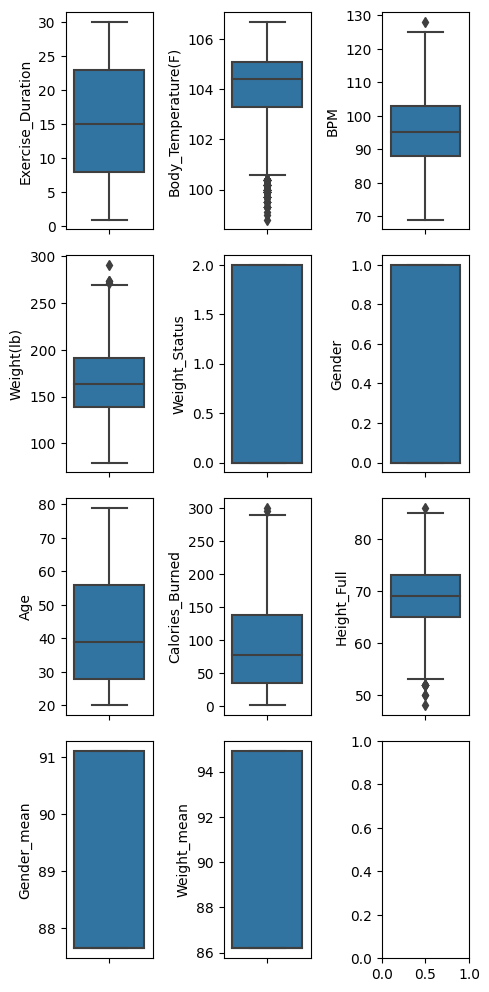

In [79]:
fig, axes = plt.subplots(len(train_df.columns) // 3 + 1,3, figsize = (5,10))

for idx, col in enumerate(train_df.columns):
  sns.boxplot(y = train_df[col], ax = axes[idx//3][idx % 3])
plt.tight_layout()
plt.show()

In [6]:
# body temperature은 log transformation
# bpm, height_full, weight(lb) 이상치 확인

""" IQR 처리 """
outlier_column = ['BPM','Weight(lb)','Calories_Burned']
for i in outlier_column:
  Q1 = train_df[i].quantile(0.25)
  Q3 = train_df[i].quantile(0.75)

  IQR = Q3 - Q1
  MIN = Q1 - 1.5 * IQR
  MAX = Q3 + 1.5 * IQR
  target = train_df[(train_df[i] < MIN) | (train_df[i] > MAX)]
  train_df.drop(target.index, inplace = True)
  print(f'{len(target.index)} data is outlier')
print(f'Delete the data...')

1 data is outlier
11 data is outlier
3 data is outlier
2 data is outlier
Delete the data...


In [80]:
mm_list =[]

for idx,i in enumerate(train_df.columns):
  if i == 'Calories_Burned' :
    continue
  mm = MinMaxScaler()
  fitted = mm.fit(train_df[i].values.reshape(-1,1))
  result = mm.transform(train_df[i].values.reshape(-1,1))
  train_df[i] = result.reshape(-1)
  mm_list.append(mm)
for idx, i in enumerate(test_df.columns):
  result = mm_list[idx].transform(test_df[i].values.reshape(-1,1))
  test_df[i] = result.reshape(-1)

In [44]:
!pip install autogluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/req_command.py", line 241, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/commands/install.py", line 419, in run
    requirement_set = resolver.resolve(
  File "/

In [81]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label = 'Calories_Burned', eval_metric = 'rmse',problem_type = 'regression' ) . fit(train_data = train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20230416_140819/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230416_140819/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    7500
Train Data Columns: 10
Label Column: Calories_Burned
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11854.91 MB
	Train Data (Original)  Memory Usage: 0.6 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	

[1000]	valid_set's rmse: 1.60544
[2000]	valid_set's rmse: 1.42464
[3000]	valid_set's rmse: 1.36232
[4000]	valid_set's rmse: 1.33394
[5000]	valid_set's rmse: 1.32296
[6000]	valid_set's rmse: 1.31891
[7000]	valid_set's rmse: 1.31727
[8000]	valid_set's rmse: 1.31376
[9000]	valid_set's rmse: 1.31234
[10000]	valid_set's rmse: 1.31305


	-1.3102	 = Validation score   (-root_mean_squared_error)
	9.75s	 = Training   runtime
	1.11s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 1.48973
[2000]	valid_set's rmse: 1.41379
[3000]	valid_set's rmse: 1.40695


	-1.4048	 = Validation score   (-root_mean_squared_error)
	5.27s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-3.3305	 = Validation score   (-root_mean_squared_error)
	5.01s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-0.5728	 = Validation score   (-root_mean_squared_error)
	88.66s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-2.9411	 = Validation score   (-root_mean_squared_error)
	4.92s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-1.3331	 = Validation score   (-root_mean_squared_error)
	6.3s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-1.7855	 = Validation score   (-root_mean_squared_error)
	5.4s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-2.8522	 = Validation score   (-root_mean_squared_error)
	13.25s	 = Training   runtime
	0.01s	 = Validation runti

[1000]	valid_set's rmse: 1.89053
[2000]	valid_set's rmse: 1.87753
[3000]	valid_set's rmse: 1.87444
[4000]	valid_set's rmse: 1.87349
[5000]	valid_set's rmse: 1.87304
[6000]	valid_set's rmse: 1.87292
[7000]	valid_set's rmse: 1.87289
[8000]	valid_set's rmse: 1.87287
[9000]	valid_set's rmse: 1.87286
[10000]	valid_set's rmse: 1.87285


	-1.8729	 = Validation score   (-root_mean_squared_error)
	24.38s	 = Training   runtime
	1.74s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.541	 = Validation score   (-root_mean_squared_error)
	0.73s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 182.31s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230416_140819/")


In [ ]:
# male_cnt = 0 
# female_cnt = 0
# test_df['Calories_Buned'] = [0.1 for i in range(len(test_df))]
# for idx in range(len(test_df)):
#   if test_df.loc[idx,'Gender'] == 0.0:
#     test_df.loc[idx,'Calories_Burned'] = male_pred.values[male_cnt]
#     male_cnt +=1
#   else:
#     test_df.loc[idx,'Calories_Burned'] = female_pred.values[female_cnt]
#     female_cnt += 1


In [82]:
submission = pd.read_csv('./sample_submission.csv')
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               7500 non-null   object
 1   Calories_Burned  7500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.3+ KB


In [92]:
predictor.fit_weighted_ensemble(base_models = ['CatBoost','WeightedEnsemble_L2'])

Fitting model: WeightedEnsemble_4_L3Best ...
	-0.541	 = Validation score   (-root_mean_squared_error)
	0.17s	 = Training   runtime
	0.0s	 = Validation runtime


['WeightedEnsemble_4_L3Best']

In [89]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2Best  -0.541049       1.440610  110.367852                0.000552           0.389864            2       True         13
1       WeightedEnsemble_L2  -0.541049       1.440786  110.704215                0.000728           0.726227            2       True         12
2   WeightedEnsemble_L3Best  -0.541049       1.441372  110.547190                0.000762           0.179338            3       True         14
3                  CatBoost  -0.572776       0.011807   88.663619                0.011807          88.663619            1       True          6
4                LightGBMXT  -1.310180       1.107214    9.750734                1.107214           9.750734            1       True          3
5           NeuralNetFastAI  -1.333138       0.012580    6.295372         

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'WeightedEnsemble_L2Best': 'WeightedEnsembleModel',
  'WeightedEnsemble_L3Best': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -6.342529588132886,
  'KNeighborsDist': -6.190718823134154,
  'LightGBMXT': -1.3101803810073154,
  'LightGBM': -1.4048027585391503,
  'RandomForestMSE': -3.3304888237845613,
  'CatBoost': -0.5727757782349465,
  'ExtraTreesMSE': -2.9411116990659423,
  'NeuralNetFastAI': -1.3331382292001202,
  'XGBoost': -1.7854913234457783,
  'NeuralNetTorch': -2.8522030253290422,
  'LightGBMLarge': -1.872853896842458,
  'WeightedEns

In [93]:
y_pred = predictor.predict(test_df)

In [94]:
submission['Calories_Burned'] = y_pred
submission.to_csv('./submission.csv', index = False)
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               7500 non-null   object 
 1   Calories_Burned  7500 non-null   float32
dtypes: float32(1), object(1)
memory usage: 88.0+ KB
